In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DIP

Mounted at /content/drive
/content/drive/MyDrive/DIP


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
train_path='Dataset/Cloth Defect Detection.v3i.multiclass/train'
valid_path='Dataset/Cloth Defect Detection.v3i.multiclass/valid'
test_path='Dataset/Cloth Defect Detection.v3i.multiclass/test'
classes='/_classes.csv'
train_df=pd.read_csv(train_path+classes)
test_df=pd.read_csv(test_path+classes)
valid_df=pd.read_csv(valid_path+classes)
train_df.columns=['filename', 'Broken-Button', 'Button', 'Color', 'Hole', 'Swing','yarn']
test_df.columns=['filename', 'Broken-Button', 'Button', 'Color', 'Hole', 'Swing','yarn']
valid_df.columns=['filename', 'Broken-Button', 'Button', 'Color', 'Hole', 'Swing','yarn']
train_df.head(2)

,filename,Broken-Button,Button,Color,Hole,Swing,yarn
0,IMG-20240501-WA0027_jpg.rf.d7b5983d6bfebedac99...,1,0,0,0,0,0
1,IMG-20240501-WA0051_jpg.rf.d83af70aa1df5010cf5...,1,0,0,0,0,0


In [6]:
from tqdm import tqdm
import cv2
import os
target_size=(640, 640)

def load_images_and_labels(df, directory):
    dataset = []
    total_samples = len(df)
    i=0
    for index, row in tqdm(df.iterrows(), total=total_samples, desc="Loading Images"):
        if(i==10):
          break
        i+=1
        filename = row['filename']
        filepath = os.path.join(directory, filename)

        img = cv2.imread(filepath)
        img = cv2.resize(img, target_size)

        label = row[['Broken-Button', 'Button', 'Color', 'Hole', 'Swing', 'yarn']].values.tolist()

        dataset.append((img, label))
    return dataset

def get_x_y_from_dataset(dataset):
    X = np.array([data_point[0] for data_point in dataset])
    y = np.array([data_point[1] for data_point in dataset])
    return X, y

In [7]:
train_data=load_images_and_labels(train_df,train_path)
test_data=load_images_and_labels(test_df,test_path)
valid_data=load_images_and_labels(valid_df,valid_path)

Loading Images:  18%|█▊        | 10/55 [00:04<00:20,  2.25it/s]


In [9]:
X_train, y_train = get_x_y_from_dataset(train_data)
X_test, y_test = get_x_y_from_dataset(test_data)
X_valid, y_valid = get_x_y_from_dataset(valid_data)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_valid:", y_valid.shape)

Shape of X_train: (10, 640, 640, 3)
Shape of y_train: (10, 6)
Shape of X_test: (10, 640, 640, 3)
Shape of y_test: (10, 6)
Shape of X_valid: (10, 640, 640, 3)
Shape of y_valid: (10, 6)


In [10]:
from sklearn.model_selection import train_test_split

merged_X = np.concatenate([X_train, X_test, X_valid], axis=0)
merged_y = np.concatenate([y_train, y_test, y_valid], axis=0)
print("Shape of merged_X:", merged_X.shape)
print("Shape of merged_y:", merged_y.shape)



Shape of merged_X: (30, 640, 640, 3)
Shape of merged_y: (30, 6)


Original images shape: (30, 640, 640, 3)
Augmented images shape: (150, 640, 640, 3)


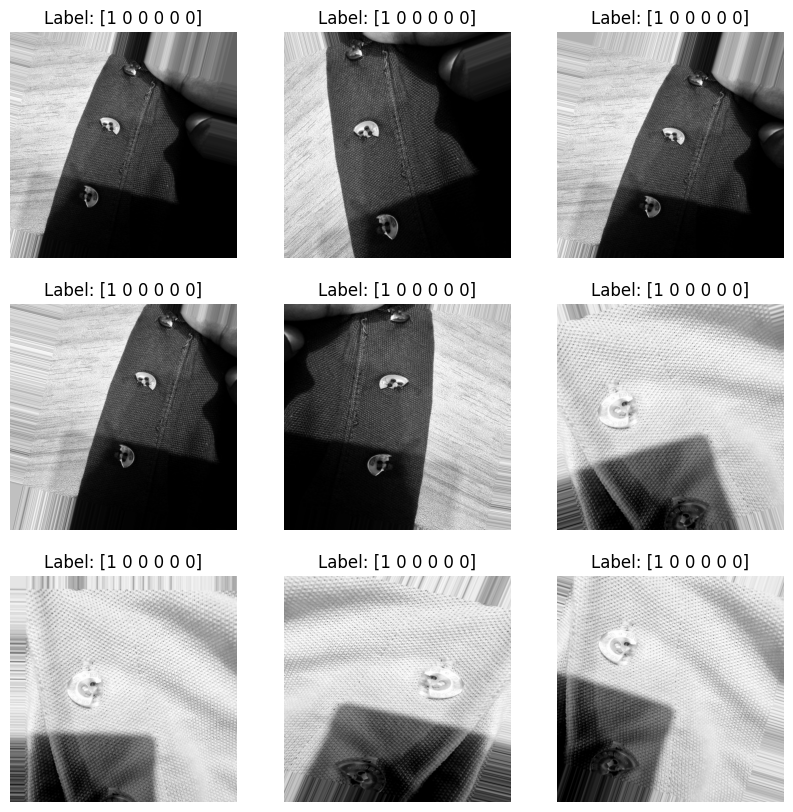

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(images, labels, augmentation_factor):
    augmented_images = []
    augmented_labels = []

    labels = np.array(labels)

    # Create an ImageDataGenerator object for augmentation
    datagen = ImageDataGenerator(
        rotation_range=30,  # Random rotation within ±20 degrees
        width_shift_range=0.1,  # Random horizontal shift
        height_shift_range=0.1,  # Random vertical shift
        shear_range=0.3,  # Shear intensity
        zoom_range=0.2,  # Random zoom
        horizontal_flip=True,  # Random horizontal flip
        fill_mode='nearest'  # Fill mode for points outside input boundaries
    )

    # Reshape images to 4D array
    images = np.array(images)
    images = images.reshape((len(images),) + images[0].shape)

    # Generate augmented images
    for img, label in zip(images, labels):
        # Reshape the image to (1, height, width, channels) for the flow method
        img = img.reshape((1,) + img.shape)
        i = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            augmented_labels.append(label)
            i += 1
            if i >= augmentation_factor:
                break  # Break the loop after reaching the desired number of augmentations

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_labels

augmentation_factor = 5

augmented_images, augmented_labels = augment_images(merged_X, merged_y, augmentation_factor)

# Print the shape of augmented data
print("Original images shape:", merged_X.shape)
print("Augmented images shape:", augmented_images.shape)

# Optionally, visualize some of the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].astype(np.uint8))
    plt.title(f"Label: {augmented_labels[i]}")
    plt.axis("off")
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(merged_X, merged_y, test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

In [ ]:
VGG16 = tf.keras.models.load_model('Bestmodels/vgg16_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5')
ResNet50 = tf.keras.models.load_model('Bestmodels/resnet50_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5')
MobileNet = tf.keras.models.load_model('Bestmodels/MobileNet_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5')
InceptionV3 = tf.keras.models.load_model('Bestmodels/inception_v3_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5')
Xception = tf.keras.models.load_model('Bestmodels/xception_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5')

In [ ]:
from sklearn.metrics import accuracy_score

predictions_VGG16 = VGG16.predict(X_test)
predictions_ResNet50 = ResNet50.predict(X_test)
predictions_InceptionV3 = InceptionV3.predict(X_test)
predictions_Xception = Xception.predict(X_test)

# Convert probabilities to class labels
predicted_classes_VGG16 = np.argmax(predictions_VGG16, axis=-1)
predicted_classes_ResNet50 = np.argmax(predictions_ResNet50, axis=-1)
predicted_classes_InceptionV3 = np.argmax(predictions_InceptionV3, axis=-1)
predicted_classes_Xception = np.argmax(predictions_Xception, axis=-1)




1/1 [==============================] - 14s 14s/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
predicted_classes_VGG16 = np.argmax(predictions_VGG16, axis=-1)
predicted_classes_ResNet50 = np.argmax(predictions_ResNet50, axis=-1)
predicted_classes_InceptionV3 = np.argmax(predictions_InceptionV3, axis=-1)
predicted_classes_Xception = np.argmax(predictions_Xception, axis=-1)

# Convert one-hot encoded y_test back to integer labels
true_classes = np.argmax(y_test, axis=-1)

# Compute individual accuracies
accuracy_VGG16 = accuracy_score(true_classes, predicted_classes_VGG16)
accuracy_ResNet50 = accuracy_score(true_classes, predicted_classes_ResNet50)
accuracy_InceptionV3 = accuracy_score(true_classes, predicted_classes_InceptionV3)
accuracy_Xception = accuracy_score(true_classes, predicted_classes_Xception)

# Ensemble predictions using majority voting
ensemble_predictions = predictions_VGG16 + predictions_ResNet50 + predictions_InceptionV3 + predictions_Xception
final_predictions = np.argmax(ensemble_predictions, axis=-1)

# Compute ensemble accuracy
ensemble_accuracy = accuracy_score(true_classes, final_predictions)

In [ ]:
print("Individual Accuracies:")
print("VGG16 Accuracy:", accuracy_VGG16)
print("ResNet50 Accuracy:", accuracy_ResNet50)
print("InceptionV3 Accuracy:", accuracy_InceptionV3)
print("Xception Accuracy:", accuracy_Xception)

print("Ensemble Accuracy (Majority Voting):", ensemble_accuracy)

Individual Accuracies:
VGG16 Accuracy: 1.0
ResNet50 Accuracy: 0.9615384615384616
InceptionV3 Accuracy: 0.8076923076923077
Xception Accuracy: 0.9615384615384616
Ensemble Accuracy (Majority Voting): 0.9615384615384616


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their corresponding metrics
models = ['VGG16', 'ResNet50', 'InceptionV3', 'InceptionResNetV2', 'Xception']
macro_avg_precision = [0.87, 0.70, 0.53, 0.07, 0.57]
macro_avg_recall = [0.73, 0.73, 0.47, 0.17, 0.58]
macro_avg_f1_score = [0.74, 0.70, 0.46, 0.10, 0.57]

# Plotting
x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting macro average precision
rects1 = ax.bar(x - width, macro_avg_precision, width, label='Precision', color='skyblue')
# Plotting macro average recall
rects2 = ax.bar(x, macro_avg_recall, width, label='Recall', color='lightgreen')
# Plotting macro average F1-score
rects3 = ax.bar(x + width, macro_avg_f1_score, width, label='F1-score', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Macro Average Precision, Recall, and F1-score for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['YOLOv8M', 'YOLOv8 OBB']
precision = [0.95, 0.819]
recall = [0.564, 0.686]
mAP50 = [0.621, 0.664]
mAP50_95 = [0.394, 0.521]

# Plotting
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(6, 6))

# Precision
plt.subplot(2, 2, 1)
plt.bar(x, precision, width=0.3, color=['skyblue', 'salmon'])
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.xticks(x, models)

# Recall
plt.subplot(2, 2, 2)
plt.bar(x, recall, width=0.3, color=['skyblue', 'salmon'])
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.xticks(x, models)

# mAP50
plt.subplot(2, 2, 3)
plt.bar(x, mAP50, width=0.3, color=['skyblue', 'salmon'])
plt.xlabel('Models')
plt.ylabel('mAP50')
plt.title('mAP50 Comparison')
plt.xticks(x, models)

# mAP50-95
plt.subplot(2, 2, 4)
plt.bar(x, mAP50_95, width=0.3, color=['skyblue', 'salmon'])
plt.xlabel('Models')
plt.ylabel('mAP50-95')
plt.title('mAP50-95 Comparison')
plt.xticks(x, models)

plt.tight_layout()
plt.show()


In [ ]:
ensemble_predictions = (predictions_model1 + predictions_model2 + predictions_model3) / 3

# Take the class with the highest probability as the final prediction
final_predictions = np.argmax(ensemble_predictions, axis=1)

# Assuming you have ground truth labels stored in 'true_labels'
# Calculate accuracy
true_labels = np.random.randint(0, 5, size=100)  # Example ground truth labels
accuracy = np.mean(final_predictions == true_labels)
print("Ensemble accuracy:", accuracy)